In [109]:
%matplotlib inline

In [247]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

In [248]:
import glob
import os

def get_latest_file_glob(pat):    
    list_of_files = glob.glob(pat) # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [249]:
latest_niv = get_latest_file_glob('data/corona_tested_individuals_ver_*.csv.gz')
niv = pd.read_csv(latest_niv, 
                  encoding='utf-8-sig', low_memory=False, na_values=['None'],
                  parse_dates=[0])
#niv['test_date'] = niv.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
niv.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-07-02,1,0,0,0,0,שלילי,No,זכר,Other
1,2020-07-02,0,0,0,0,0,שלילי,No,זכר,Other
2,2020-07-02,1,0,0,0,0,שלילי,No,נקבה,Abroad
3,2020-07-02,0,0,0,0,0,שלילי,No,זכר,Other
4,2020-07-02,0,0,0,0,0,שלילי,No,נקבה,Other


In [250]:
symptom_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']
niv['symp_num'] = niv[symptom_cols].fillna(0).sum(axis=1).astype(int)
niv['no_symp'] = (~niv[symptom_cols].fillna(0).any(axis=1))
symptom_cols.append('no_symp')


In [251]:
latest_bdi = get_latest_file_glob('data/corona_lab_tests_ver_*.csv.gz')
bdi = pd.read_csv(latest_bdi, encoding='utf-8', parse_dates=[0,1])

In [252]:
bdi['orig_test_date'] = bdi.test_date
bdi['test_date'] = bdi.test_date.combine_first(bdi.result_date)

In [253]:
bdi.head()

,test_date,result_date,corona_result,lab_id,is_first_Test,orig_test_date
0,2020-03-18,2020-03-18,חיובי,32,No,NaT
1,2020-03-18,2020-03-18,חיובי,1,No,NaT
2,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
3,2020-03-20,2020-03-20,שלילי,4,Yes,NaT
4,2020-03-20,2020-03-20,שלילי,4,Yes,NaT


In [254]:
bdi.shape

(1216068, 6)

In [255]:
bdi.corona_result.value_counts()

שלילי               1135183
חיובי                 59932
לא בוצע/פסול 999      14062
חיובי גבולי            5879
בעבודה                  615
לא ודאי                 397
Name: corona_result, dtype: int64

In [256]:
niv.corona_result.value_counts()

שלילי    734839
חיובי     25302
אחר        9224
Name: corona_result, dtype: int64

In [257]:
niv.test_indication.value_counts()

Other                     724701
Abroad                     27472
Contact with confirmed     17192
Name: test_indication, dtype: int64

In [258]:
niv.age_60_and_above.value_counts()

No     253209
Yes     44362
Name: age_60_and_above, dtype: int64

In [259]:
niv.loc[(niv.test_indication=='Other') & (niv.no_symp), 'test_indication'] = 'Other-Unknown'
niv.loc[(niv.test_indication=='Other-Unknown') & (niv.age_60_and_above=='Yes'), 'test_indication'] = 'Other-60_above'
niv.loc[(niv.test_indication=='Other') & (~niv.no_symp), 'test_indication'] = 'Other-Symptoms'

In [260]:
result_map = {
    'חיובי': 'positive',
    'שלילי': 'negative',
    'אחר': 'other',
    'לא בוצע': 'not_done',
    'בעבודה': 'in_progress',
    'לא ודאי': 'uncertain',
}
niv['corona_result'] = niv.corona_result.map(result_map)


In [261]:
bdi['corona_result'] = bdi.corona_result.map(result_map)

In [262]:
rec = pd.read_csv(get_latest_file_glob('data/corona_recovered_ver_*.csv.gz'), encoding='utf-8-sig')
rec = rec.iloc[:, 0:5]
rec.head()

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
0,78,9,60+,נקבה,Contact with confirmed
1,37,9,50-59,נקבה,Contact with confirmed
2,37,9,20-29,נקבה,Contact with confirmed
3,31,9,30-39,זכר,Contact with confirmed
4,28,9,60+,נקבה,Contact with confirmed


In [263]:
x = (rec
 .assign(total_tests_count = lambda x: (x.fillna('3').total_tests_count
                                .astype(str).str.replace('>=', '').str.replace('+', '')
                                .astype(int)))
 .groupby('total_tests_count').days_between_pos_and_neg.agg(['size', 'min', 'max', 'mean', 'median'])
).reset_index()
x['test_sum'] = x.total_tests_count*x['size']
x

,total_tests_count,size,min,max,mean,median,test_sum
0,2,3,6,12,9.666667,11,6
1,3,7715,2,96,16.408296,16,23145
2,4,3681,2,98,21.006248,21,14724
3,5,2522,2,84,24.457970,24,12610
4,6,1558,6,96,27.594352,27,9348
5,7,969,8,63,30.380805,30,6783
6,8,561,3,68,33.338681,33,4488
7,9,345,3,78,35.681159,35,3105
8,10,559,5,106,41.103757,41,5590


In [264]:
rec.iloc[rec.days_between_pos_and_neg.nlargest(10).index]

,days_between_pos_and_neg,total_tests_count,age_group,gender,test_indication
17504,106,10+,0-19,נקבה,Contact with confirmed
17678,100,10+,60+,זכר,Contact with confirmed
17671,99,10+,60+,זכר,Other
6959,98,4,40-49,נקבה,Other
3306,96,6,30-39,זכר,Other
14825,96,3,20-29,נקבה,Other
7405,95,4,60+,זכר,Contact with confirmed
3225,93,6,60+,נקבה,Contact with confirmed
3513,84,5,60+,נקבה,Contact with confirmed
9488,83,4,20-29,זכר,Other


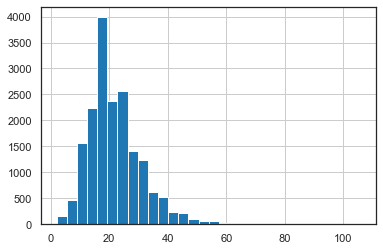

In [265]:
rec.days_between_pos_and_neg.hist(bins=30)

In [266]:
iso = pd.read_csv(get_latest_file_glob('data/corona_isolation_per_day_ver_*.csv.gz'),
                  encoding='utf-8-sig', low_memory=False)
iso.head()

,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad
0,2020-07-08,50399,8734,7543,606
1,2020-07-07,47172,8495,7222,613
2,2020-07-06,43533,8396,6768,722
3,2020-07-05,39588,8211,9120,668
4,2020-07-04,32206,7793,5042,529


In [267]:
niv.dtypes

test_date              datetime64[ns]
cough                           int64
fever                           int64
sore_throat                     int64
shortness_of_breath             int64
head_ache                       int64
corona_result                  object
age_60_and_above               object
gender                         object
test_indication                object
symp_num                        int32
no_symp                          bool
dtype: object

In [268]:
niv.age_60_and_above.value_counts()

No     253209
Yes     44362
Name: age_60_and_above, dtype: int64

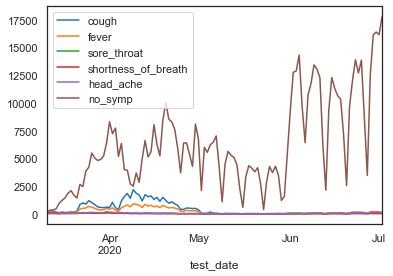

In [269]:
niv.groupby('test_date')[symptom_cols].sum().plot()

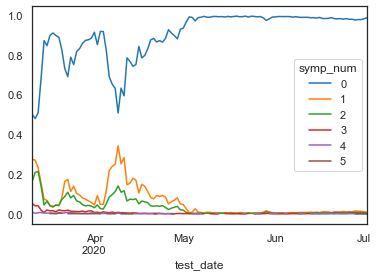

In [270]:
sn = niv.groupby(['test_date', 'symp_num']).size().unstack()
(sn.div(sn.sum(axis=1), axis=0)).plot()

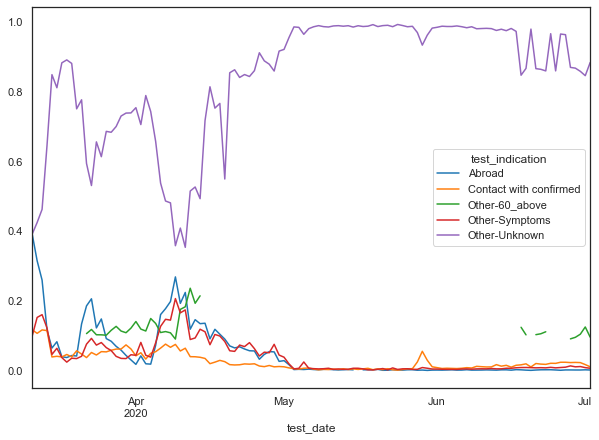

In [271]:
ti = niv.groupby(['test_date', 'test_indication']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot(figsize=(10,7))

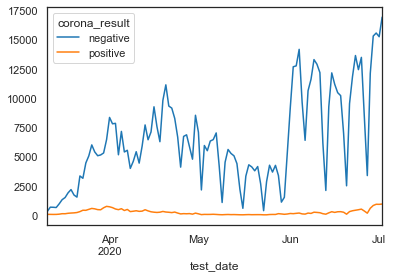

In [272]:
niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [273]:
bdi.dtypes

test_date         datetime64[ns]
result_date       datetime64[ns]
corona_result             object
lab_id                     int64
is_first_Test             object
orig_test_date    datetime64[ns]
dtype: object

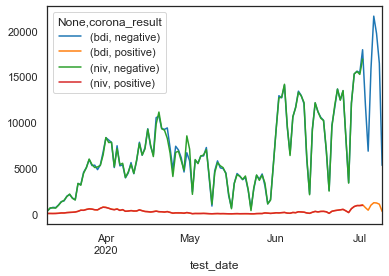

In [274]:
pd.concat([bdi[(bdi.test_date>'2020') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack(),
           niv[niv.corona_result!='other'].groupby(['test_date', 'corona_result']).size().unstack()], keys=['bdi', 'niv'], axis=1).plot()

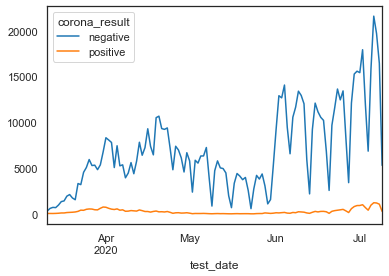

In [275]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')].groupby(['test_date', 'corona_result']).size().unstack().plot()

In [276]:
bdi[(bdi.test_date<'2021') & (bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='No')].groupby(['test_date', 'corona_result']).size().unstack()

corona_result,negative,positive
test_date,,
2020-03-11,3,3
2020-03-12,20,6
2020-03-13,17,2
2020-03-14,25,3
2020-03-15,70,45
...,...,...
2020-07-05,8103,512
2020-07-06,7533,505
2020-07-07,7749,537


In [277]:
pone = bdi[(bdi.test_date<'2021') & (bdi.is_first_Test=='Yes')].fillna('Other').groupby(['test_date', 'corona_result']).size().unstack()
pone[pone.positive<20]

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-05-02,36.0,NaN,2375.0,18.0,NaN
2020-05-08,27.0,NaN,3947.0,18.0,NaN
2020-05-09,31.0,NaN,849.0,9.0,NaN
2020-05-12,46.0,NaN,5021.0,19.0,NaN
2020-05-14,60.0,1.0,4469.0,16.0,NaN
2020-05-15,28.0,NaN,1979.0,7.0,NaN
2020-05-16,24.0,NaN,675.0,4.0,NaN
2020-05-17,59.0,NaN,3341.0,15.0,NaN
2020-05-19,32.0,NaN,4124.0,12.0,NaN


In [278]:
pone.tail(5)

corona_result,Other,in_progress,negative,positive,uncertain
test_date,,,,,
2020-07-05,153.0,1.0,15808.0,950.0,NaN
2020-07-06,219.0,NaN,21598.0,1213.0,NaN
2020-07-07,218.0,1.0,19700.0,1188.0,NaN
2020-07-08,162.0,NaN,16449.0,1056.0,NaN
2020-07-09,88.0,1.0,5293.0,266.0,NaN


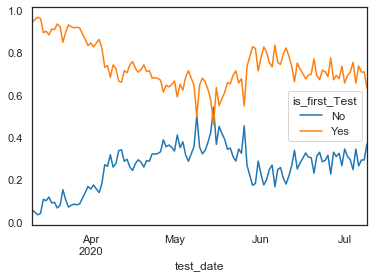

In [279]:
ti = bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')].groupby(['test_date', 'is_first_Test']).size().unstack()
(ti.div(ti.sum(axis=1), axis=0)).plot()

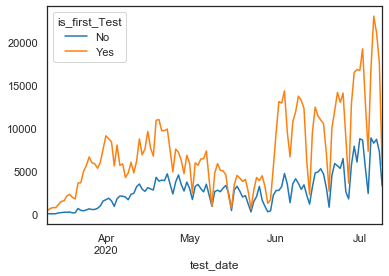

In [280]:
ti.plot()

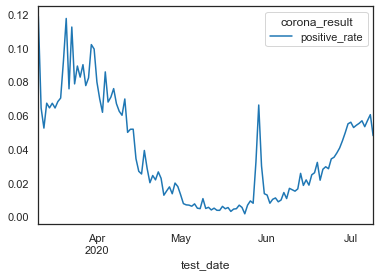

In [281]:
(bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative))[['positive_rate']]
 .plot())

In [282]:
import altair as alt
ti.tail()

is_first_Test,No,Yes
test_date,,
2020-07-05,8862,16912
2020-07-06,8247,23030
2020-07-07,8692,21107
2020-07-08,7288,17667
2020-07-09,3285,5648


In [283]:
ti.Yes.sum() + ti.No.sum()

1216068

In [284]:
alt.Chart(ti.reset_index().assign(total=lambda x: x.Yes+x.No)).mark_line().encode(
    x='test_date',
    y='Yes',
    tooltip=['test_date', 'Yes']
).interactive()

alt.Chart(...)

In [285]:
pr = (bdi[(bdi.test_date>'2020') & (bdi.test_date<'2021')&(bdi.corona_result.isin(['positive', 'negative'])) & (bdi.is_first_Test=='Yes')]
 .groupby(['test_date', 'corona_result']).size().unstack()
 .assign(positive_rate=lambda x: x.positive/(x.positive+x.negative)))

alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate']
).interactive()

alt.Chart(...)

In [286]:
alt.Chart(pr.reset_index()).mark_bar().encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive']
).interactive()

alt.Chart(...)

In [337]:
hos_cols = {'תאריך': 'date',
            'חולים קשה': 'critical',
            'חולים בינוני': 'medium',
            'מונשמים': 'resp'}

In [338]:
hos = (pd.read_csv(get_latest_file_glob('data/corona_hospitalization_ver_*.csv.gz'), encoding='utf-8-sig', low_memory=False, na_values=['None'])
      .rename(columns=hos_cols)
      .assign(date = lambda x: x.date.apply(pd.to_datetime))
      .assign(critical = lambda x: x.critical.str.replace('<15', '15').astype(int))
      .assign(medium = lambda x: x.medium.fillna('<15').str.replace('<15', '15').astype(int))
      .assign(resp = lambda x: x.resp.str.replace('<15', '15').astype(int)))
#hos['test_date'] = hos.test_date.apply(pd.to_datetime, format='%Y-%m-%d')
hos.head()

,date,מאושפזים,אחוז נשים מאושפזות,גיל ממוצע מאושפזים,סטיית תקן גיל מאושפזים,resp,אחוז נשים מונשמות,גיל ממוצע מונשמים,סטיית תקן גיל מונשמים,חולים קל,...,גיל ממוצע חולים קל,סטיית תקן גיל חולים קל,medium,אחוז נשים חולות בינוני,גיל ממוצע חולים בינוני,סטיית תקן גיל חולים בינוני,critical,אחוז נשים חולות קשה,גיל ממוצע חולים קשה,סטיית תקן גיל חולים קשה
0,2020-03-11,75,36.0,48.0,17.4,15,20.0,63.0,15.3,68,...,47.0,16.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
1,2020-03-12,97,39.2,50.0,18.0,15,20.0,63.0,15.3,90,...,49.0,17.7,15,NaN,NaN,NaN,15,33.3,67.0,16.2
2,2020-03-13,115,39.1,49.0,17.9,15,20.0,63.0,15.3,105,...,47.0,17.3,15,50.0,64.0,17.3,15,33.3,67.0,16.2
3,2020-03-14,153,41.2,47.0,18.3,15,0.0,70.0,7.4,144,...,46.0,17.5,15,50.0,64.0,17.3,15,20.0,76.0,10.3
4,2020-03-15,192,44.3,46.0,18.6,15,20.0,74.0,7.6,178,...,45.0,17.5,15,50.0,58.0,14.9,15,37.5,79.0,9.1


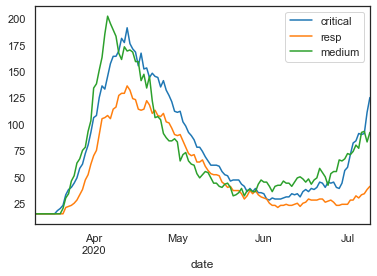

In [340]:
(hos[['date', 'critical', 'resp', 'medium']].set_index('date').plot())

In [341]:
hos_and_rate = hos[['date', 'critical', 'resp', 'medium']].rename(columns={'date': 'test_date'}).merge(pr, on='test_date')
hos_and_rate.head()


,test_date,critical,resp,medium,negative,positive,positive_rate
0,2020-03-11,15,15,15,319,43,0.118785
1,2020-03-12,15,15,15,597,41,0.064263
2,2020-03-13,15,15,15,706,39,0.052349
3,2020-03-14,15,15,15,681,49,0.067123
4,2020-03-15,15,15,15,960,66,0.064327


In [325]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [303]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.12]
               .assign(positive = lambda x: x.positive.ewm(span=7).mean())
               .assign(positive_label ='positive')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive',
    tooltip=['test_date', 'positive'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical')
               .assign(critical = lambda x: x.critical.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='critical',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positives (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

No handles with labels found to put in legend.


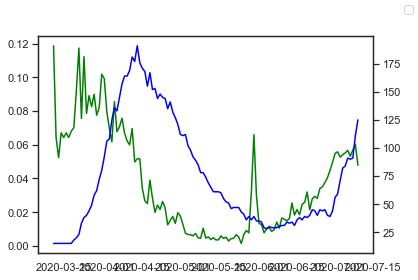

In [293]:
sns.lineplot(data=hos_and_rate[hos_and_rate.positive_rate<0.12].set_index('test_date').positive_rate, color="g")
ax2 = plt.twinx()
sns.lineplot(data=hos_and_rate.set_index('test_date').critical, color="b", ax=ax2)
ax2.figure.legend()


In [342]:
c1 = alt.Chart(hos_and_rate[hos_and_rate.positive_rate<0.115]
               .assign(positive_rate = lambda x: x.positive_rate.ewm(span=7).mean())
               .assign(positive_label ='positive_rate')).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='positive_rate',
    tooltip=['test_date', 'positive_rate'],
    shape='positive_label'
)
c2 = alt.Chart(hos_and_rate
               .assign(critical_label='critical+med')
               .assign(crit_med = lambda x: (x.critical+x.medium).ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_med',
    tooltip=['test_date', 'critical'],
    opacity='critical_label'
)


alt.layer(c1, c2).resolve_scale(y='independent').properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)

In [322]:
hos_and_rate['pos_pct_change'] = hos_and_rate.positive_rate.pct_change()
hos_and_rate['crit_pct_change'] = hos_and_rate.critical.pct_change()


In [324]:
c1 = alt.Chart(hos_and_rate
               .assign(pos_pct_change = lambda x: x.pos_pct_change.ewm(span=7).mean())
              ).mark_line(color='cornflowerblue').encode(
    x='test_date',
    y='pos_pct_change',
    tooltip=['test_date', 'positive_rate'],
)
c2 = alt.Chart(hos_and_rate
               .assign(crit_pct_change = lambda x: x.crit_pct_change.ewm(span=7).mean())
              ).mark_line(color='crimson').encode(
    x='test_date',
    y='crit_pct_change',
    tooltip=['test_date', 'critical'],
)


alt.layer(c1, c2).properties(title='Positive rate (smoothed, 7d) vs. critical hospitalizations (smoothed, 7d), by date')


alt.LayerChart(...)